# Imports

In [1]:
import time
import numpy as np
import torch
from torchvision import transforms as T
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter

import sys
sys.path.append("..")

from data import pacs

from models import resnet_ms
from models import custom_models

from utils import utils

# Config

## Regarding Dataset

In [2]:
NUM_CLASSES = 7
CLASSES = ["dog", "elephant", "giraffe", "guitar", "horse", "house", "person"]
DOMAINS = ["art_painting", "cartoon", "photo", "sketch"]

## Hyperparameters

In [3]:
EPOCHS = 25
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
REGULARIZATION = 1e-4
MOMENTUM = 0.9
MODEL = custom_models.resnet50_ms12_a0d1_fr123
USE_PRETRAINED = True
OPTIMIZER = optim.SGD
OPTIMIZER_KWARGS = {
    "lr": LEARNING_RATE,
    "weight_decay": REGULARIZATION,
    "momentum": MOMENTUM
}
SCHEDULER = optim.lr_scheduler.CosineAnnealingLR # optim.lr_scheduler.ReduceLROnPlateau
SCHEDULER_KWARGS = {"T_max": EPOCHS} # {"mode": "min", "patience": 5}
EARLY_STOPPING_PATIENCE = 5
EARLY_STOPPING_DELTA = 1e-5
AUGMENTATIONS = ()
NUM_SEEDS = 3

## Debug

In [4]:
verbose = True

## Image Normalization

In [5]:
# Values for pretrained ResNet
pretrained_image_transform = T.Compose([
    *AUGMENTATIONS,
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Device

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
if verbose:
    print(f"Device: {device}")

Device: cuda


## Abstract model building, optimizer and scheduler

In [7]:
build_model = lambda: MODEL(NUM_CLASSES, loss='softmax', pretrained=USE_PRETRAINED, verbose=verbose)
build_optimizer = lambda model: OPTIMIZER(model.parameters(), **OPTIMIZER_KWARGS)
build_scheduler = lambda optimizer: SCHEDULER(optimizer, **SCHEDULER_KWARGS)

# Set seed for reproducibility

In [8]:
# seed = 42
# torch.manual_seed(42)
# if device == torch.device("cuda"):
#     torch.cuda.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True

# Training

In [9]:
writer = SummaryWriter()
%load_ext tensorboard
%tensorboard --logdir ./runs

Reusing TensorBoard on port 6006 (pid 25156), started 8 days, 0:22:02 ago. (Use '!kill 25156' to kill it.)

## Training Loop

In [10]:
class AverageMeter:
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [11]:
def accuracy(target, output):
    batch_size = target.shape[0]
    _, pred = torch.max(output, dim=-1)
    correct = pred.eq(target).sum()
    return correct.item() / batch_size

In [15]:
def train(epoch: int,
        target_domain: str,
        data_loader:torch.utils.data.DataLoader,
        model: nn.Module,
        optimizer: optim.Optimizer
        ) -> tuple[float, float]:
    """train one epoch"""
    model.train()
    losses = AverageMeter()
    accs = AverageMeter()

    for i, (data, _domain, target) in enumerate(data_loader):
        # Print progress every 20 batches for debugging
        if verbose and i % 20 == 0 and i > 0:
            print(f"Batch {i+1}/{len(data_loader)}")

        step = (epoch - 1) * len(data_loader) + i + 1
        data = data.to(device)
        target = target.to(device)

        out = model(data)
        loss = F.cross_entropy(out, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = accuracy(target, out)
        losses.update(loss.item(), out.shape[0])
        accs.update(acc, out.shape[0])

        writer.add_scalar(f'Loss/Train/target={target_domain}', loss.item(), step)
        writer.add_scalar(f'Accuracy/Train/target={target_domain}', acc, step)

    return losses.avg, accs.avg

## Evaluation

In [16]:
def evaluate(data_loader: torch.utils.data.DataLoader, model: nn.Module, phase="val") -> tuple[float, float]:
    model.eval()

    losses = AverageMeter()
    accs = AverageMeter()

    with torch.no_grad():
        for data, _domain, target in data_loader:
            data = data.to(device)
            target = target.to(device)

            out = model(data)

            # The implementation returns only the feature vector rather than the classification logits.
            # To compare the labels, we therefore must apply the classification layer manually:
            out = model.classifier(out)

            loss = F.cross_entropy(out, target)
            acc = accuracy(target, out)

            losses.update(loss.item(), out.shape[0])
            accs.update(acc, out.shape[0])
    
    return losses.avg, accs.avg

## Training Loop

Starting training...


Seeds:   0%|          | 0/3 [00:00<?, ?it/s]

Target Domain:   0%|          | 0/4 [00:00<?, ?it/s]

Processing target domain: art_painting
Freezing the following layers ['layer1', 'layer2', 'layer3']
Using model's pretrained normalization stats
Loading data for target domain art_painting...


Epoch (art_painting):   0%|          | 0/25 [00:00<?, ?it/s]


Epoch 1/25 for art_painting. Training...
Batch 21/248
Batch 41/248
Batch 61/248
Batch 81/248
Batch 101/248
Batch 121/248
Batch 141/248
Batch 161/248
Batch 181/248
Batch 201/248
Batch 221/248
Batch 241/248
Training done in 25.88s - Loss: 0.8743, Acc: 0.7153
Creating visualization...


Extracting features:   0%|          | 0/128 [00:00<?, ?it/s]

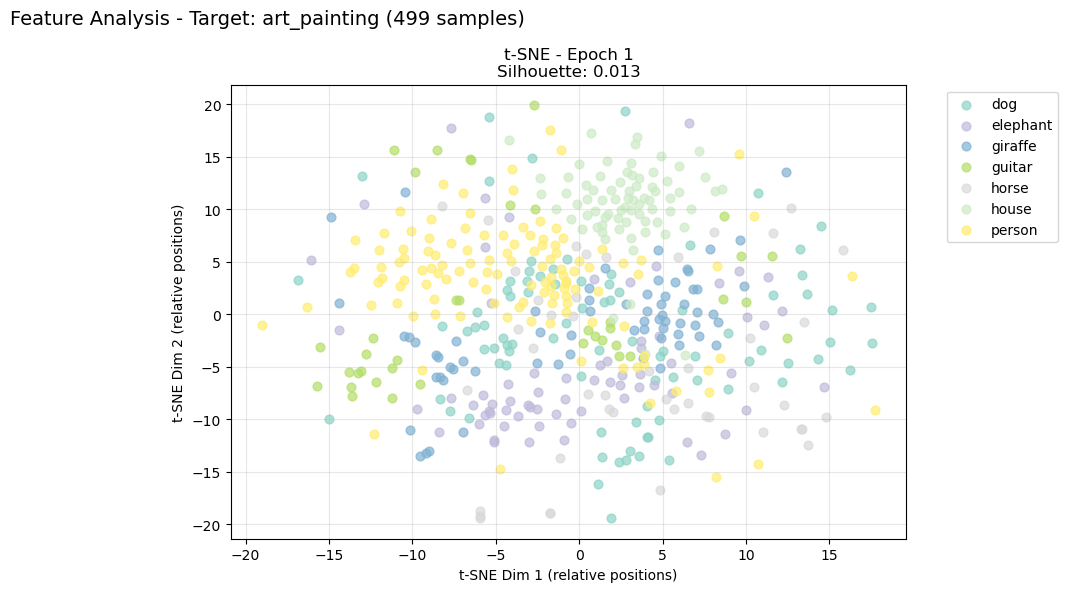

Saving best model (loss: 0.8447)


RuntimeError: Parent directory ../checkpoints/pacs does not exist.

In [19]:
all_results = {d: [] for d in DOMAINS}
all_results['avgs'] = []
all_results['worst'] = []

if verbose:
    print("Starting training...")

for _ in tqdm(range(NUM_SEEDS), desc="Seeds"):
    results = {}

    for target_domain in tqdm(DOMAINS, desc="Target Domain"):
        if verbose:
            print(f"Processing target domain: {target_domain}")

        model = build_model()
        model = model.to(device)

        optimizer = build_optimizer(model)
        scheduler = build_scheduler(optimizer)

        if not USE_PRETRAINED:
            if verbose:
                print(f"Computing normalization stats excluding domain {target_domain}...")

            img_mean, img_std = pacs.get_normalization_stats(target_domain)

            if verbose:
                print(f"Normalization values excluding domain {target_domain}:\n\tmean: {img_mean}\n\tstd: {img_std}")

            image_transform = T.Compose([
                *AUGMENTATIONS,
                T.Resize(256),
                T.CenterCrop(224),
                T.ToTensor(),
                T.Normalize(mean=img_mean, std=img_std)
            ])
        else:
            image_transform = pretrained_image_transform
            if verbose:
                print(f"Using model's pretrained normalization stats")

        if verbose:
            print(f"Loading data for target domain {target_domain}...")

        train_loader, val_loader = pacs.get_data_loaders(target_domain, train_batch_size=BATCH_SIZE, transform=image_transform, shuffle_test=True, drop_last=True)

        best_loss = float('inf')
        patience_counter = 0

        feature_tracker = None
        epoch_results = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
        
        for epoch in tqdm(range(1, EPOCHS + 1), desc=f"Epoch ({target_domain})"):
            if verbose:
                print(f"\nEpoch {epoch}/{EPOCHS} for {target_domain}. Training...")

            start_time = time.time()
            train_loss, train_acc = train(
                epoch, target_domain, train_loader, model, optimizer)
            train_time = time.time() - start_time
            if verbose:
                print(f"Training done in {train_time:.2f}s - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")

            val_loss, val_acc = evaluate(val_loader, model)

            epoch_results["train_loss"].append(train_loss)
            epoch_results["train_acc"].append(train_acc)
            epoch_results["val_loss"].append(val_loss)
            epoch_results["val_acc"].append(val_loss)

            writer.add_scalar(f"Loss/Test/target={target_domain}", val_loss, epoch)
            writer.add_scalar(f"Accuracy/Test/target={target_domain}", val_acc, epoch)

            scheduler.step() # scheduler.step(val_loss) if scheduler needs criterium

            # create visualization   max_samples set to 499 due to RAM constraints
            if verbose:
                print("Creating visualization...")
            feature_tracker = utils.track_feature_evolution(model, val_loader, epoch, target_domain, feature_tracker,
                                                            visualize_every=1, max_samples=499, save_dir=f"../model_comparison/pacs/features/{target_domain}")

            if best_loss - val_loss < EARLY_STOPPING_DELTA and (patience_counter := patience_counter+1) > EARLY_STOPPING_PATIENCE:
                if verbose:
                    print(f"Early stopping triggered (patience: {patience_counter})")
                break

            if val_loss < best_loss:
                best_loss = val_loss
                if verbose:
                    print(f"Saving best model (loss: {best_loss:.4f})")
                torch.save(model.state_dict(), f"../checkpoints/pacs/best_{target_domain}.pt")

        if verbose:
            print(f"\nTraining summary for target domain {target_domain}:")
            print(f"  Best validation accuracy: {max(epoch_results['val_acc']):.4f} (epoch {np.argmax(epoch_results['val_acc'])+1})")
            print(f"  Final validation accuracy: {epoch_results['val_acc'][-1]:.4f}")
            print(f"  Best validation loss: {min(epoch_results['val_loss']):.4f} (epoch {np.argmin(epoch_results['val_loss'])+1})")
            print(f"  Final validation loss: {epoch_results['val_loss'][-1]:.4f}")

        if verbose:
            print("\nLoading best model for final evaluation...")
        model.load_state_dict(torch.load(f"../checkpoints/pacs/best_{target_domain}.pt"))
        _, acc = evaluate(val_loader, model, phase="final")
        if verbose:
            print(f"Final accuracy for target domain {target_domain}: {acc:.4f}\n")

        results[target_domain] = acc

    avg_acc = np.mean([*results.values()])
    worst_case_acc = np.min([*results.values()])

    for d in DOMAINS:
        all_results[d].append(results[d])
    all_results['avgs'].append(avg_acc)
    all_results['worst'].append(worst_case_acc)

print("Average Accuracy:\n" +
      "{}".format("".join(f"\t{d}: {np.mean(all_results[d]):.4f}, std: {np.std(all_results[d]):.4f}\n" for d in DOMAINS)) +
      f"\ttotal: {np.mean(all_results['avgs']):.4f}, std: {np.std(all_results['avgs']):.4f}\n"
      "Worst-case Accuracy:\n" +
      "{}".format("".join(f"\t{d}: {np.min(all_results[d]):.4f}\n" for d in DOMAINS)) +
      f"\ttotal: {np.mean(all_results['worst']):.4f}, std: {np.std(all_results['worst']):.4f}"
)

In [ ]:
print("Average Accuracy:\n" +
      "{}".format("".join(f"\t{d}: {np.mean(all_results[d]):.4f}, std: {np.std(all_results[d]):.4f}\n" for d in DOMAINS)) +
      f"\ttotal: {np.mean(all_results['avgs']):.4f}, std: {np.std(all_results['avgs']):.4f}\n"
      "Worst-case Accuracy:\n" +
      "{}".format("".join(f"\t{d}: {np.min(all_results[d]):.4f}\n" for d in DOMAINS)) +
      f"\ttotal: {np.mean(all_results['worst']):.4f}, std: {np.std(all_results['worst']):.4f}"
      )

Average Accuracy:
	art_painting: 0.8877, std: 0.0063
	cartoon: 0.7674, std: 0.0121
	photo: 0.9818, std: 0.0007
	sketch: 0.7550, std: 0.0136
	total: 0.8480, std: 0.0005
Worst-case Accuracy:
	art_painting: 0.8823
	cartoon: 0.7526
	photo: 0.9808
	sketch: 0.7439
	total: 0.7478, std: 0.0036
